Notebook to implement population model gradient descent to learn parametesr such as p_sympt, p_severe, p_hosp

In [1]:
import datetime
import turicreate as tc
import matplotlib.pyplot as plt
plt.rcParams.update({'font.size': 20})
covidestim_csv = 'covidestim.csv'
# estimates = tc.SFrame(covidestim_csv)
# print(estimates['state'].unique())
state_long = 'Massachusetts'
state_short = 'MA' 

results_folder = 'results/'
data_folder = 'data/'

%load_ext autoreload
%autoreload 2
# from PopulationData_ag_before_conv import PopulationData
from PopulationData_ag_interpRT import PopulationData
from HospitalData_v20210507 import HospitalData
# import random
import autograd


RELOADING_RESULTS = False

training_mid_dates = [20210501,  20210501] # start mid end, where forecasting happens from mid to end
# training_mid_dates = [20201010,  20201120] # start mid end, where forecasting happens from mid to end
forecast_duration = 25
training_end_dates = [int((datetime.datetime.strptime(str(d),'%Y%m%d') 
                       + datetime.timedelta(days = forecast_duration)).strftime('%Y%m%d')) for d in training_mid_dates]


# print(training_end_dates)
def make_forecastable_csv(date):
    pd_dummy = PopulationData(covidestim_csv, state_long,'20210101', date, forecast=False);
    pd_dummy.filtered_data.save(data_folder+state_short+ '_forecast_after_' + str(date) + '.csv', format='csv') 

hd_truthful = HospitalData('HHS_UMN_data.csv', state_short,'20210101','20210601')
pd_truthful = PopulationData(covidestim_csv, state_long,'20210101', '20210601', forecast=False);
# pd_truthful.filtered_data['date'].unique().sort()[-10:-1]

if not RELOADING_RESULTS:
    for d in training_mid_dates:
        make_forecastable_csv(d)

pd_list = []
for i,(m,e) in enumerate(zip(training_mid_dates,training_end_dates)):
    pd_list += [PopulationData(data_folder+state_short+ '_forecast_after_'+str(m) + '.csv',state_long,'20210101',str(e), training_mode=True, debug_mode=True)]



pd_list_train = pd_list[0:-1]
pd_list_val = pd_list[-1:]

Finished parsing file /Users/cuongnguyen/Desktop/pop_cv19/data/HHS_data.csv

Parsing completed. Parsed 100 lines in 0.216362 secs.

------------------------------------------------------
Inferred types from first 100 line(s) of file as 
column_type_hints=[str,str,int,int,int,int,int,int,int,int,int,int,int,int,int,int,int,int,int,int,int,int,int,int,int,int,int,int,int,int,int,int,int,int,int,int,int,int,int,int,float,int,int,int,float,int,int,int,float,int,int,int,float,int,int,int,float,int,int,int,str,int,int,int,int,int,int,int,int,int,int,int,int,int,int,int,int,int,int,int,int,int,int,int,int,int,int,int,int,int,int,int,int,int,int,int,int]
If parsing fails due to incorrect types, you can correct
the inferred type list above and pass it to read_csv in
the column_type_hints argument
------------------------------------------------------


Finished parsing file /Users/cuongnguyen/Desktop/pop_cv19/data/HHS_data.csv

Parsing completed. Parsed 24714 lines in 0.255368 secs.

Finished parsing file /Users/cuongnguyen/Desktop/pop_cv19/data/UMN_data.csv

Parsing completed. Parsed 100 lines in 0.08977 secs.

------------------------------------------------------
Inferred types from first 100 line(s) of file as 
column_type_hints=[int,str,str,str,str,str,str,int,str,int,int,int,str,float,int]
If parsing fails due to incorrect types, you can correct
the inferred type list above and pass it to read_csv in
the column_type_hints argument
------------------------------------------------------


Finished parsing file /Users/cuongnguyen/Desktop/pop_cv19/data/UMN_data.csv

Parsing completed. Parsed 22713 lines in 0.095344 secs.

Finished parsing file /Users/cuongnguyen/Desktop/pop_cv19/data/covidestim.csv

Parsing completed. Parsed 100 lines in 0.181925 secs.

------------------------------------------------------
Inferred types from first 100 line(s) of file as 
column_type_hints=[str,str,float,float,float,float,float,float,float,float,float,float,float,float,float,float,float,float,float,float,float,float,float,float,float,float,float,float,float,float,float,float,float,float,float,float,float,float,float,float,float,str]
If parsing fails due to incorrect types, you can correct
the inferred type list above and pass it to read_csv in
the column_type_hints argument
------------------------------------------------------


Finished parsing file /Users/cuongnguyen/Desktop/pop_cv19/data/covidestim.csv

Parsing completed. Parsed 25556 lines in 0.24962 secs.

Finished parsing file /Users/cuongnguyen/Desktop/pop_cv19/data/covidestim.csv

Parsing completed. Parsed 100 lines in 0.247937 secs.

------------------------------------------------------
Inferred types from first 100 line(s) of file as 
column_type_hints=[str,str,float,float,float,float,float,float,float,float,float,float,float,float,float,float,float,float,float,float,float,float,float,float,float,float,float,float,float,float,float,float,float,float,float,float,float,float,float,float,float,str]
If parsing fails due to incorrect types, you can correct
the inferred type list above and pass it to read_csv in
the column_type_hints argument
------------------------------------------------------


Finished parsing file /Users/cuongnguyen/Desktop/pop_cv19/data/covidestim.csv

Parsing completed. Parsed 25556 lines in 0.342396 secs.

Finished parsing file /Users/cuongnguyen/Desktop/pop_cv19/data/covidestim.csv

Parsing completed. Parsed 100 lines in 0.238947 secs.

------------------------------------------------------
Inferred types from first 100 line(s) of file as 
column_type_hints=[str,str,float,float,float,float,float,float,float,float,float,float,float,float,float,float,float,float,float,float,float,float,float,float,float,float,float,float,float,float,float,float,float,float,float,float,float,float,float,float,float,str]
If parsing fails due to incorrect types, you can correct
the inferred type list above and pass it to read_csv in
the column_type_hints argument
------------------------------------------------------


Finished parsing file /Users/cuongnguyen/Desktop/pop_cv19/data/covidestim.csv

Parsing completed. Parsed 25556 lines in 0.289626 secs.

Finished parsing file /Users/cuongnguyen/Desktop/pop_cv19/data/MA_forecast_after_20210501.csv

Parsing completed. Parsed 100 lines in 0.025954 secs.

------------------------------------------------------
Inferred types from first 100 line(s) of file as 
column_type_hints=[str,int,float,str,str,float,str,str,float,float,str,str,float,str,str,str,str,float,str,str,float,str,str,float,str,str,float,str,str,float,str,str,float,str,str,float,float,str,str,str,str,str,int]
If parsing fails due to incorrect types, you can correct
the inferred type list above and pass it to read_csv in
the column_type_hints argument
------------------------------------------------------


Finished parsing file /Users/cuongnguyen/Desktop/pop_cv19/data/MA_forecast_after_20210501.csv

Parsing completed. Parsed 121 lines in 0.007717 secs.

Finished parsing file /Users/cuongnguyen/Desktop/pop_cv19/covidestim.csv

Parsing completed. Parsed 100 lines in 0.187284 secs.

------------------------------------------------------
Inferred types from first 100 line(s) of file as 
column_type_hints=[str,str,float,float,float,float,float,float,float,float,float,float,float,float,float,float,float,float,float,float,float,float,float,float,float,float,float,float,float,float,float,float,float,float,float,float,float,float,float,float,float,str]
If parsing fails due to incorrect types, you can correct
the inferred type list above and pass it to read_csv in
the column_type_hints argument
------------------------------------------------------


Finished parsing file /Users/cuongnguyen/Desktop/pop_cv19/covidestim.csv

Parsing completed. Parsed 25504 lines in 0.286214 secs.

Finished parsing file /Users/cuongnguyen/Desktop/pop_cv19/data/MA_forecast_after_20210501.csv

Parsing completed. Parsed 100 lines in 0.053125 secs.

------------------------------------------------------
Inferred types from first 100 line(s) of file as 
column_type_hints=[str,int,float,str,str,float,str,str,float,float,str,str,float,str,str,str,str,float,str,str,float,str,str,float,str,str,float,str,str,float,str,str,float,str,str,float,float,str,str,str,str,str,int]
If parsing fails due to incorrect types, you can correct
the inferred type list above and pass it to read_csv in
the column_type_hints argument
------------------------------------------------------


Finished parsing file /Users/cuongnguyen/Desktop/pop_cv19/data/MA_forecast_after_20210501.csv

Parsing completed. Parsed 121 lines in 0.038531 secs.

Finished parsing file /Users/cuongnguyen/Desktop/pop_cv19/covidestim.csv

Parsing completed. Parsed 100 lines in 0.350958 secs.

------------------------------------------------------
Inferred types from first 100 line(s) of file as 
column_type_hints=[str,str,float,float,float,float,float,float,float,float,float,float,float,float,float,float,float,float,float,float,float,float,float,float,float,float,float,float,float,float,float,float,float,float,float,float,float,float,float,float,float,str]
If parsing fails due to incorrect types, you can correct
the inferred type list above and pass it to read_csv in
the column_type_hints argument
------------------------------------------------------


Finished parsing file /Users/cuongnguyen/Desktop/pop_cv19/covidestim.csv

Parsing completed. Parsed 25504 lines in 0.332475 secs.

In [2]:
hd_truthful.filtered_data

previous_day_admission_adult_covid_confirmed ...,total_adult_patients_hospitalized_confirmed_covid ...,staffed_icu_adult_patients_confirmed_covid ...,previous_day_admission_adult_covid_confirmed_c ...,total_adult_patients_hospitalized_confirmed_co ...
309,1993,411,101,101
255,1997,414,101,101
267,2067,422,101,101
229,2067,424,79,79
325,2010,474,79,79
280,2020,477,102,102
297,1984,439,102,102
282,1959,444,102,102
269,1874,457,102,102
228,1878,450,102,102


In [3]:
def get_truthdict_given_mid_end(mid_date,end_date):
#     print(mid_date,end_date, 'mid date end date')
    pd_truthful.start_date = mid_date
    pd_truthful.end_date = end_date
    hd_truthful.start_date = mid_date
    hd_truthful.end_date = end_date
    truthdict = {
    'date':pd_truthful.filtered_data['date'],
    'infections':pd_truthful.filtered_data['infections'],
    'Rt':pd_truthful.filtered_data['Rt'],
    'symptomatic':pd_truthful.filtered_data['symptomatic'],
    'severe':pd_truthful.filtered_data['severe'],
    'hosp':hd_truthful.filtered_data['previous_day_admission_adult_covid_confirmed'],
    }

    return truthdict


def add_to_dict(d,g):
    for k in d.keys():
        d[k]=d[k]+g[k]
    return d

def scale_dict_vals(d,s_txn,s_soj):
    for k in d.keys():
        if k in ['T_serial','prob_sympt_s','prob_severe_s','prob_hosp_s']:
            d[k] = s_txn*d[k]
        elif k in ['prob_soujourn_inf_alpha_s', 'prob_soujourn_inf_beta_s', 'prob_soujourn_symp_alpha_s', 'prob_soujourn_symp_beta_s']:
            d[k] = s_soj*d[k]
        else:
            print('UNHANDLED SCALE DICT k=', k)
    return d

def cumsum_dict_vals(d,s):
    cumsum= 0
    for k in d.keys():

        cumsum+=abs(s*d[k])
    return cumsum

import numpy as np
softplus = lambda x: np.log(1+np.exp(x))
softplus_inv = lambda x: np.log(np.exp(x) -1)
from scipy.special import expit as sigmoid
from scipy.special import logit as sigmoid_inv

import numpy.random as random
def gradient_descent(pd_list_train, init_params, n_iters=2, step_size_txn=0.001, step_size_soj=0.001, n_steps_between_print=5, lambda_reg = 1, epsilon_stop=5e-10):
    grads_per_iteration = {k: [] for k in list(init_params.keys())}
    batch_loss_per_iteration = []
    val_loss_per_iteration = []
    for n in range(n_iters):
        
        batch_loss = 0
        for pd in pd_list_train:
            pd.loss_per_iteration += [0]
        
        #         pd_batch = random.choice(pd_list_train,replace=False, size=3)
        pd_batch = random.choice(pd_list_train,replace=False, size=1)
        if n == 0:
            new_params = init_params
        else:
            new_params = add_to_dict(new_params, scale_dict_vals(grads, -1*step_size_txn,-1*step_size_soj))
        
        
        for i,pd in enumerate(pd_batch):
            pd.training_mode=True
            new_grad = pd.get_grad_of_loss(new_params,get_truthdict_given_mid_end(pd.filtered_data['date'][-1], pd.end_date) ,lambda_reg= lambda_reg)
            batch_loss += pd.loss_per_iteration[-1] # pd.loss_per_iteration[-1] is set to loss within get_grad_of_loss call
            if i == 0:
                grads = new_grad
            else:
#                 grads = add_to_dict(grads, new_grad)
                grads = new_grad
#         print(grads)
        grads = scale_dict_vals(grads, 1/len(pd_batch),1/len(pd_batch))
        for k in grads_per_iteration.keys():
            grads_per_iteration[k] += [grads[k]]
        batch_loss_per_iteration += [batch_loss/len(pd_batch)]
#         print(batch_loss/len(pd_batch), 'loss at iteration ', n, '*** gradients_cummsum = ', cumsum_dict_vals(grads, step_size_))
        print(batch_loss/len(pd_batch), 'loss at iteration ', n)
#         print(cumsum_dict_vals(grads,1), 'cumsum for ', grads)
        
#         pd_list_val = pd_batch # DEBUG PURPOSES
        
        val_loss_per_iteration += [np.nan]
        if n%n_steps_between_print == 0:
            val_loss = 0              
            for pd in pd_list_val:
                fig, [ax1, ax2, ax3, ax4] = plt.subplots(nrows=1, ncols=4,figsize=(15,4))    
                pd.training_mode=False
                fc_data = pd.get_forecasted_data(new_params) 
                pd.training_mode=True
                truth_data = get_truthdict_given_mid_end(pd.filtered_data['date'][-1],pd.end_date)
#                 print('***grads***','\n',grads,'\n')
                ax1.plot(fc_data['infections'])
                ax2.plot(fc_data['symptomatic'])
                ax3.plot(fc_data['severe'])
                ax4.plot(fc_data['hosp'])

                ax1.plot(truth_data['infections'])
                ax2.plot(truth_data['symptomatic'])
                ax3.plot(truth_data['severe'])
                ax4.plot(truth_data['hosp'])
                for i in range(1,5,1):
                    eval('ax' + str(i) + '.grid()') 
                plt.show()
                print('new_params = ',new_params,'\n')
                loss = 0
                for i,k in enumerate(['hosp']):
                    val_loss+=np.sum(np.abs(np.array(fc_data[k]) - np.array(truth_data[k]))*np.linspace(0.1, 1, num=len(fc_data[k])) )*(i+1)
            val_loss_per_iteration[-1] = val_loss/len(pd_list_val)
        
#         if cumsum_dict_vals(grads, step_size)<epsilon_stop:
#             return new_params, batch_loss_per_iteration, val_loss_per_iteration
    return new_params, batch_loss_per_iteration, val_loss_per_iteration,grads_per_iteration

# train_params = {'T_serial':5.8,'prob_sympt':0.82,'prob_severe':0.2,'prob_hosp':0.25,'prob_soujourn_inf_alpha':3.41, 'prob_soujourn_inf_beta':0.605,'prob_soujourn_symp_alpha':1.62, 'prob_soujourn_symp_beta':0.218}
##TODO REPARAM change the relevant params to be their inverse fn transformed


214.687024605079 loss at iteration  0


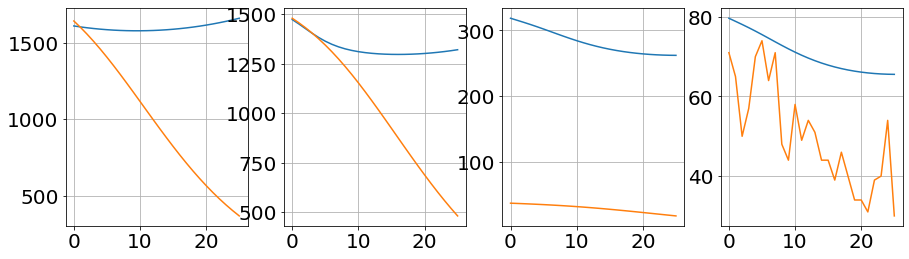

new_params =  {'T_serial': 5.8, 'prob_sympt_s': 1.5163474893680882, 'prob_severe_s': -1.3862943611198906, 'prob_hosp_s': -1.0986122886681098, 'prob_soujourn_inf_alpha_s': 3.3764006091768333, 'prob_soujourn_inf_beta_s': -0.18482202970941045, 'prob_soujourn_symp_alpha_s': 1.3994796312774522, 'prob_soujourn_symp_beta_s': -1.4122808331473442} 

212.3640838311116 loss at iteration  1
210.0908542342436 loss at iteration  2
207.8661083051396 loss at iteration  3
205.6886545324394 loss at iteration  4
203.55733612944493 loss at iteration  5


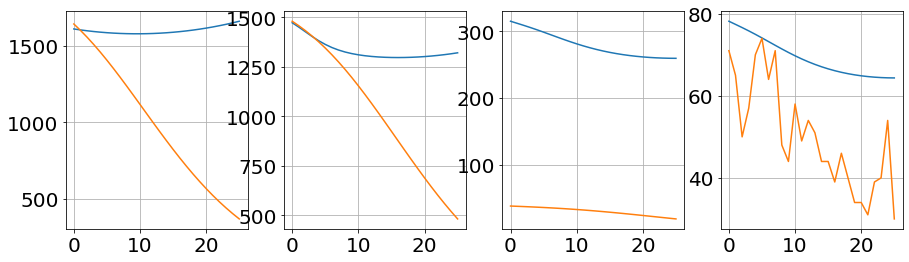

new_params =  {'T_serial': 5.8, 'prob_sympt_s': 1.513983116937928, 'prob_severe_s': -1.3980647249936429, 'prob_hosp_s': -1.109648790897643, 'prob_soujourn_inf_alpha_s': 3.3745590490332544, 'prob_soujourn_inf_beta_s': -0.17933399528686592, 'prob_soujourn_symp_alpha_s': 1.3933977332402196, 'prob_soujourn_symp_beta_s': -1.3989853076048508} 

201.47102981500473 loss at iteration  6
199.42864464588652 loss at iteration  7
197.42912089804295 loss at iteration  8
195.47142899437947 loss at iteration  9
193.55456847669547 loss at iteration  10


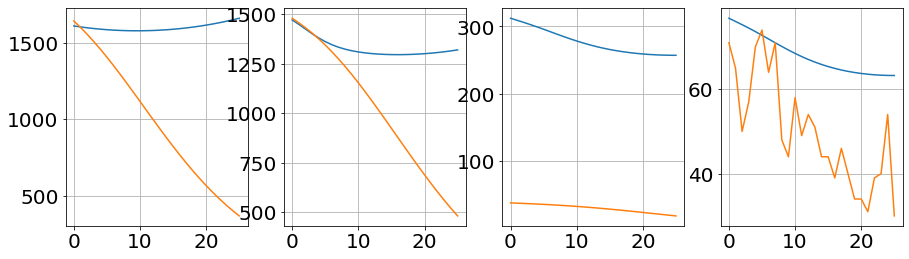

new_params =  {'T_serial': 5.8, 'prob_sympt_s': 1.5117261055007523, 'prob_severe_s': -1.4092353696120978, 'prob_hosp_s': -1.120127120428468, 'prob_soujourn_inf_alpha_s': 3.372853795351727, 'prob_soujourn_inf_beta_s': -0.17424128807630787, 'prob_soujourn_symp_alpha_s': 1.387814170089122, 'prob_soujourn_symp_beta_s': -1.3867414010112782} 



In [4]:
if not RELOADING_RESULTS:
    train_params = {'T_serial':5.8,'prob_sympt_s':sigmoid_inv(0.82),'prob_severe_s':sigmoid_inv(0.2),'prob_hosp_s':sigmoid_inv(0.25),
                    'prob_soujourn_inf_alpha_s':softplus_inv(3.41), 'prob_soujourn_inf_beta_s':softplus_inv(0.605),
                    'prob_soujourn_symp_alpha_s':softplus_inv(1.62), 'prob_soujourn_symp_beta_s':softplus_inv(0.218)}
    new_params, batch_loss_per_iteration, val_loss_per_iteration,grads_per_iteration = gradient_descent(
        pd_list_train, train_params, n_iters=11, step_size_txn=5e-6, step_size_soj=9e-5, n_steps_between_print=5, lambda_reg=1e-3,epsilon_stop=1e-4)



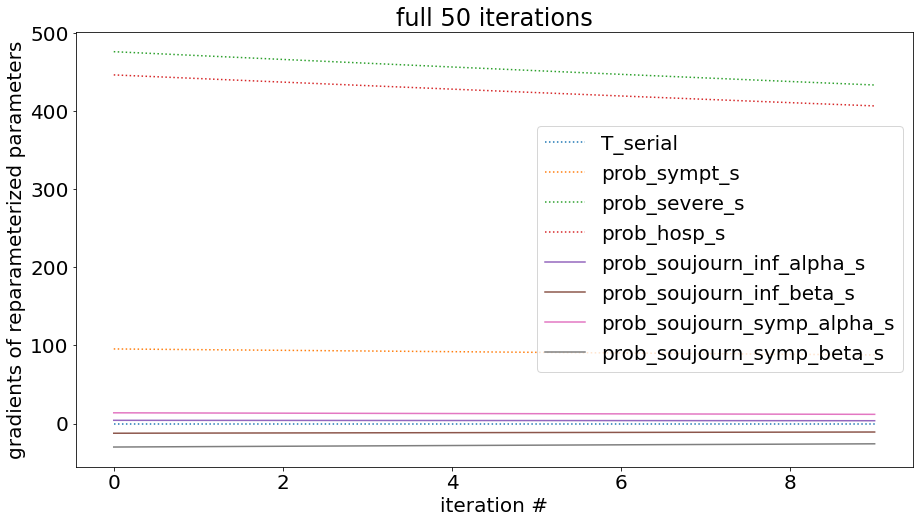

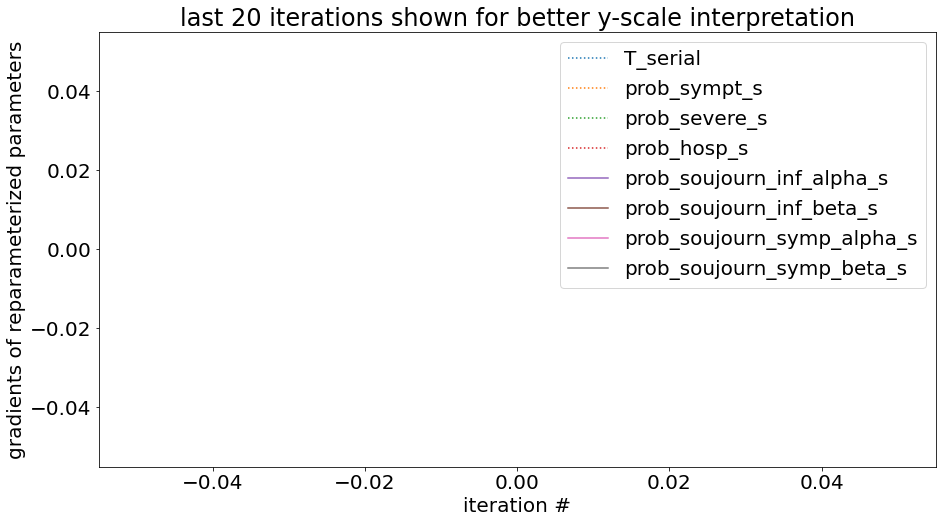

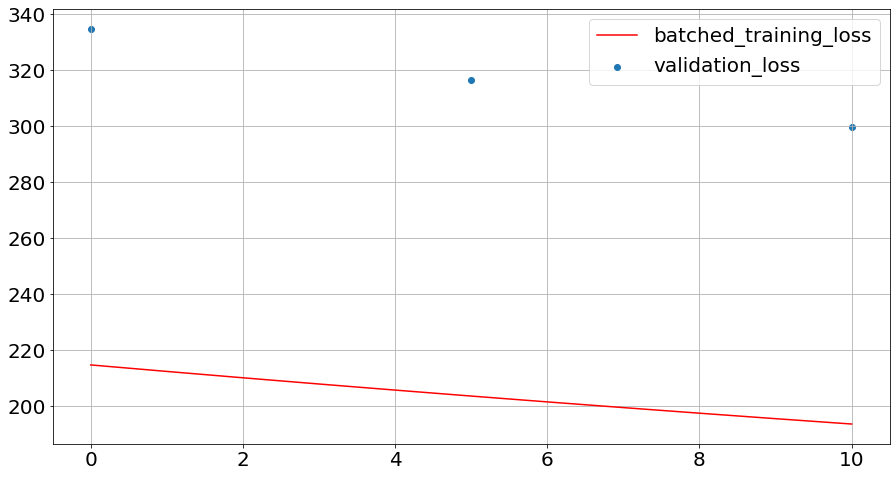

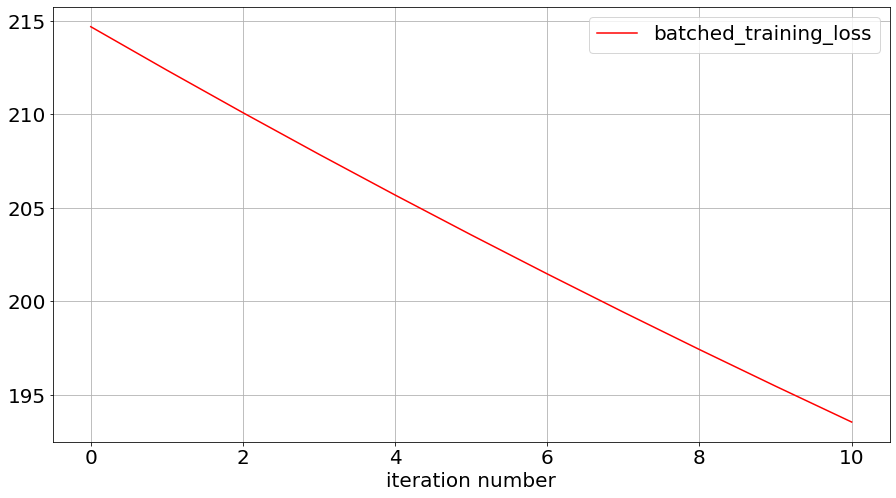

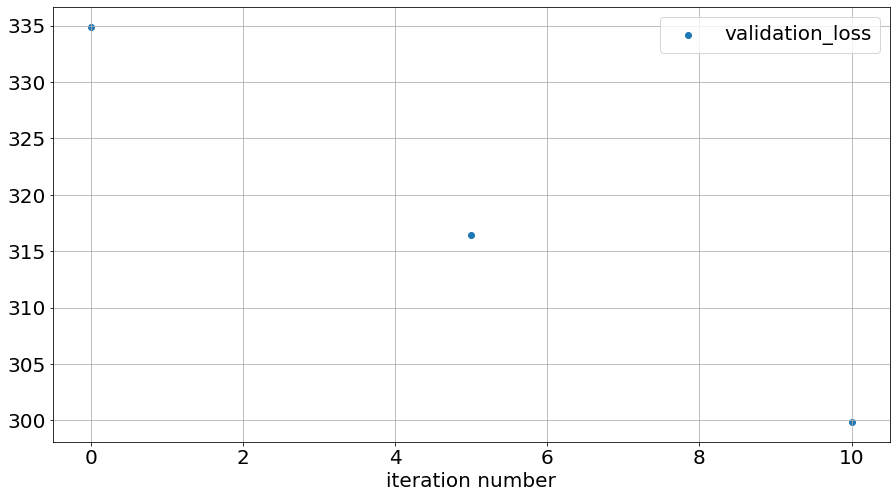

In [5]:
plt.figure(figsize=(15,8))
for k in grads_per_iteration:
    if k in ['T_serial', 'prob_sympt_s', 'prob_severe_s', 'prob_hosp_s']:
        plt.plot((grads_per_iteration[k][1:]), label=k, linestyle=':')
    else:
        plt.plot((grads_per_iteration[k][1:]), label=k, linestyle='-')
plt.legend()
plt.xlabel('iteration #')
plt.ylabel('gradients of reparameterized parameters')
plt.title('full 50 iterations')
plt.show()

plt.figure(figsize=(15,8))
for k in grads_per_iteration:
    if k in ['T_serial', 'prob_sympt_s', 'prob_severe_s', 'prob_hosp_s']:
        plt.plot((grads_per_iteration[k][30:]), label=k, linestyle=':')
    else:
        plt.plot((grads_per_iteration[k][30:]), label=k, linestyle='-')
plt.legend()
plt.xlabel('iteration #')
plt.ylabel('gradients of reparameterized parameters')
# plt.yscale('log')
plt.title('last 20 iterations shown for better y-scale interpretation')
plt.show()


# plt.rcParams.update({'font.size': 20})
fig = plt.figure(figsize=(15,8))
plt.plot(batch_loss_per_iteration,color='r', label='batched_training_loss')
# plt.show()

plt.scatter(list(range(len(val_loss_per_iteration))),val_loss_per_iteration,label='validation_loss')
plt.legend()
plt.grid()
plt.show()

fig = plt.figure(figsize=(15,8))
plt.plot(batch_loss_per_iteration,color='r', label='batched_training_loss')
plt.legend()
plt.grid()
plt.xlabel('iteration number')
plt.show()

fig = plt.figure(figsize=(15,8))
plt.scatter(list(range(len(val_loss_per_iteration))),val_loss_per_iteration,label='validation_loss')
plt.legend()
plt.grid()
plt.xlabel('iteration number')
plt.show()

# print(val_loss_per_iteration)
# import numpy as np
# np.linspace(1, 10, num=10) * np.array(np.linspace(0.1, 1, num=10))


{'T_serial': 5.8, 'prob_sympt_s': 1.5163474893680882, 'prob_severe_s': -1.3862943611198906, 'prob_hosp_s': -1.0986122886681098, 'prob_soujourn_inf_alpha_s': 3.3764006091768333, 'prob_soujourn_inf_beta_s': -0.18482202970941045, 'prob_soujourn_symp_alpha_s': 1.3994796312774522, 'prob_soujourn_symp_beta_s': -1.4122808331473442}
20210101  to  20210601
cyan = forecasts after being trained on that interval
violet = forecasts on validation/unseen interval
20210101 20210526 start and end date
20210101 20210526 start and end date
20210101 20210526 start and end date
20210101 20210526 start and end date
20210101 20210526 start and end date


<ipython-input-6-b892b1f285e8>:68: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax4.set_xticklabels(['']+ date_labels)


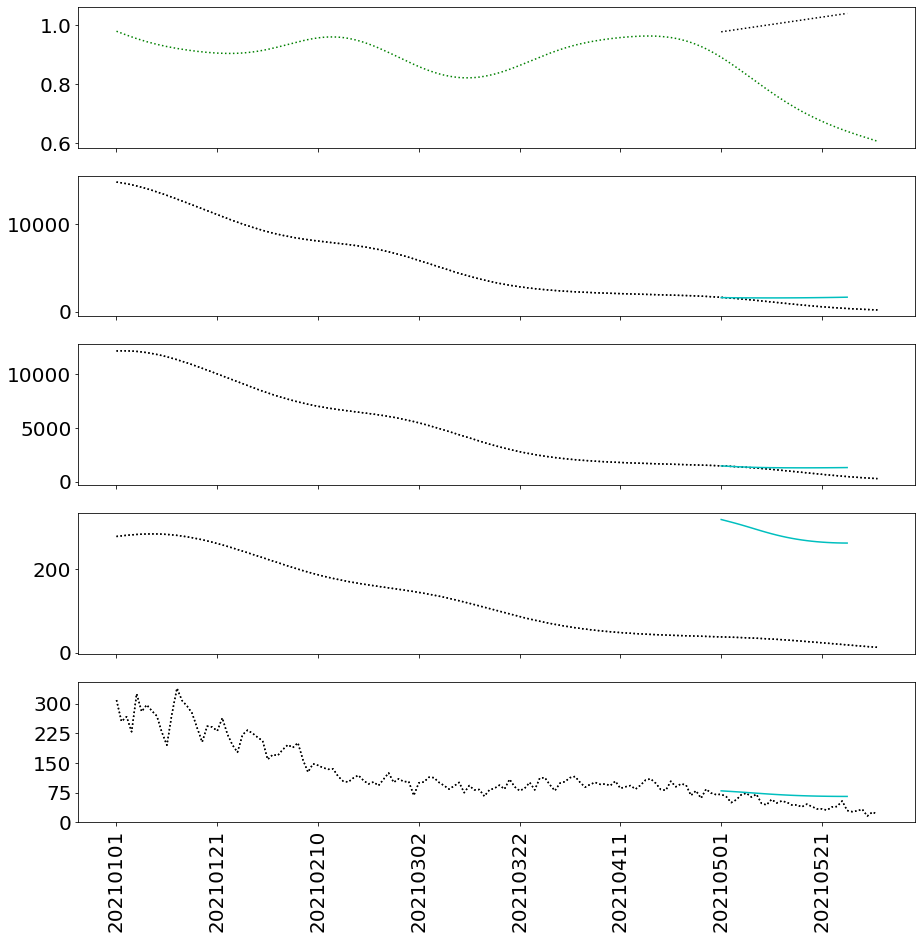

{'T_serial': 5.8, 'prob_sympt_s': 1.5117261055007523, 'prob_severe_s': -1.4092353696120978, 'prob_hosp_s': -1.120127120428468, 'prob_soujourn_inf_alpha_s': 3.372853795351727, 'prob_soujourn_inf_beta_s': -0.17424128807630787, 'prob_soujourn_symp_alpha_s': 1.387814170089122, 'prob_soujourn_symp_beta_s': -1.3867414010112782}
20210101  to  20210601
cyan = forecasts after being trained on that interval
violet = forecasts on validation/unseen interval
20210101 20210526 start and end date
20210101 20210526 start and end date
20210101 20210526 start and end date
20210101 20210526 start and end date
20210101 20210526 start and end date


<ipython-input-6-b892b1f285e8>:68: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax4.set_xticklabels(['']+ date_labels)


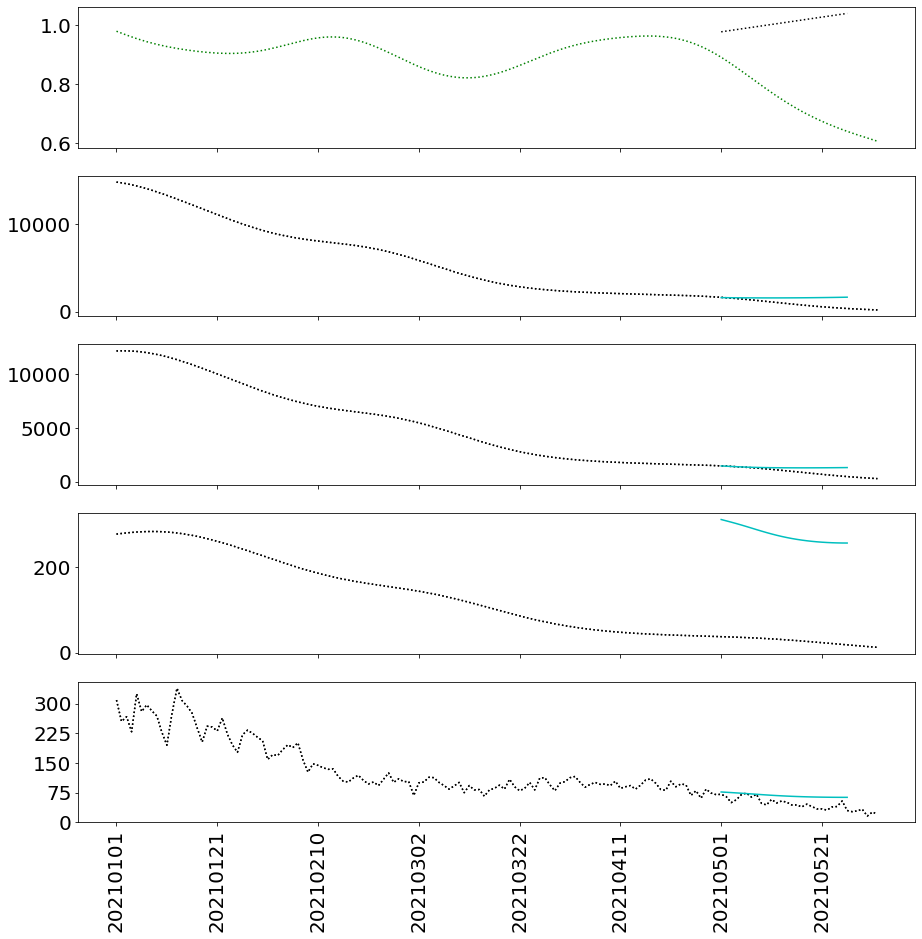

In [6]:
import math
def roundup100th(x):
    if x<=200:
        return int(math.ceil(x / 25.0)) * 25
    else:
        return int(math.ceil(x / 100.0)) * 100

def plot_performance(new_params):
    color_list = ['k','k','k','k','k']
    fig, [ax1, ax2, ax3, ax4, ax5] = plt.subplots(nrows=5, ncols=1,figsize=(15,15), sharex=True)   
    truth_data = get_truthdict_given_mid_end('20210101', '20210601')
    print(pd_truthful.start_date, ' to ', pd_truthful.end_date)
    print('cyan = forecasts after being trained on that interval')
    print('violet = forecasts on validation/unseen interval')

    



    for i,(p,c) in enumerate(zip(['Rt','infections', 'symptomatic', 'severe','hosp'],color_list)):
        if p != 'Rt':
            eval('ax'+str(i+1) + ".plot( truth_data[p], color = c,ls=':' )")
        if p == 'Rt':
            eval('ax'+str(i+1) + ".plot( truth_data[p], color = 'g',ls=':' )")
        
        if p != 'Rt':
            eval('ax'+str(i+1) + ".plot( truth_data[p], color = c,ls=':' )")
                            
        for pd in pd_list_train:
            pd.training_mode = False
            fc_data = pd.get_forecasted_data(new_params) 
            print(pd.start_date, pd.end_date, 'start and end date')
#             print(pd.start_date,pd.end_date,'start end date')
#             print(truth_data,'truth data')
#             print(fc_data[-10:],'fc_data data')
#             return
    #         '-', '--', '-.', ':',
            start_idx = list(truth_data['date']).index(int(fc_data['date'][0]))
            end_idx = start_idx + len(fc_data['date']) - 1
            if p != 'Rt':
                eval('ax'+str(i+1) + ".plot( list(range(start_idx,end_idx+1)),fc_data[p], color = 'c',ls = '-' )")
            else:
                eval('ax'+str(i+1) + ".plot( list(range(start_idx,end_idx+1)),fc_data[p], color = 'k',ls = ':' )")

        #         for pd in pd_list_val:
#         for pd in pd_list_train:
#             pd.training_mode = False
#             end_date_original = pd.end_date
#             pd.end_date = str((datetime.datetime.strptime(str(end_date_original),'%Y%m%d') + datetime.timedelta(days = forecast_duration)).strftime('%Y%m%d'))
#             fc_data = pd.get_forecasted_data(new_params) 
#     #         '-', '--', '-.', ':',
#             start_idx = list(truth_data['date']).index(int(fc_data['date'][0]))
#             end_idx = start_idx + len(fc_data['date']) - 1
#             if p != 'Rt':
#                 eval('ax'+str(i+1) + ".plot( list(range(start_idx,end_idx+1)),fc_data[p], color = 'm',ls = ':' )")
#             else:
#                 eval('ax'+str(i+1) + ".plot( list(range(start_idx,end_idx+1)),fc_data[p], color = 'k',ls = ':' )")
            
#             pd.end_date = end_date_original
#         eval('ax'+str(i+1) + '.set_title(p)')
#         eval('ax'+str(i+1) + '.grid()')
#     # current_labels = ax4.get_xticklabels()

    #     eval('ax'+str(i+1) + ".set_xticklabels( [str(d) for d in list(truth_data['date']) ] )" )
    current_labels = ax4.get_xticks();
    date_labels = [truth_data['date'][int(jj)] if jj<len(truth_data['date']) else '' for jj in list(current_labels[1:-1]) ]

    ax4.set_xticklabels(['']+ date_labels)
    
    maxy = max(int(np.max(np.array(truth_data['hosp']))),int(np.max(np.array(fc_data['hosp']))))
    ax5.set_yticks(np.arange(0, maxy, step=roundup100th(maxy/6)))
    ax5.figure.savefig(results_folder+state_short+'_hosp_forecast_trained_on_'+str(training_mid_dates[0])+'_'+str(training_end_dates[0])  +'.pdf', bbox_inches='tight')
# train_params = {'T_serial':5.8,'prob_sympt':0.536,'prob_severe':0.1,'prob_hosp':0.55,'prob_soujourn_inf_alpha':3.41, 'prob_soujourn_inf_beta':0.605,'prob_soujourn_symp_alpha':1.62, 'prob_soujourn_symp_beta':0.218}
# train_params = {'T_serial':5.8,'prob_sympt':0.82,'prob_severe':0.2,'prob_hosp':0.25,'prob_soujourn_inf_alpha':3.41, 'prob_soujourn_inf_beta':0.605,'prob_soujourn_symp_alpha':1.62, 'prob_soujourn_symp_beta':0.218}


train_params = {'T_serial':5.8,'prob_sympt_s':sigmoid_inv(0.82),'prob_severe_s':sigmoid_inv(0.2),'prob_hosp_s':sigmoid_inv(0.25),
                'prob_soujourn_inf_alpha_s':softplus_inv(3.41), 'prob_soujourn_inf_beta_s':softplus_inv(0.605),
                'prob_soujourn_symp_alpha_s':softplus_inv(1.62), 'prob_soujourn_symp_beta_s':softplus_inv(0.218)}

print(train_params)
plot_performance(train_params)
plt.xticks(rotation=90)
plt.show()

####PICKLE RELOAD NEW PARAMS IN 
if RELOADING_RESULTS:
    import pickle
    filename = results_folder+ state_short + '_population_params_trained_on_'+str(training_mid_dates[0])+'_'+str(training_end_dates[0])

    with open(filename+'.pickle', 'rb') as handle:
        new_params = pickle.load(handle)


print(new_params)
plot_performance(new_params)
plt.xticks(rotation=90)
plt.show()

In [7]:
# pd_list_train[0].end_date = '20210501'
pd_list_train[0].end_date = '20210801'
pd_list_train[0].get_forecasted_data(new_params, save_admissions=True) 

SAVE ADMISSIONS


Rt,date,hosp,infections,severe,symptomatic
0.9774025853107344,20210501,76.79328532350064,1608.6471728276283,312.18342962608625,1470.299155787944
0.9798956416597202,20210502,76.03566039779935,1602.3202882225464,309.10349956866935,1448.169092196174
0.9823886980087061,20210503,75.2676956365128,1596.7194369561364,305.9815355583987,1424.5381817069351
0.9848817543576919,20210504,74.46903975706839,1591.8353922225638,302.7348046692894,1401.1043993026544
0.9873748107066778,20210505,73.63338477498158,1587.6599247678382,299.337663406313,1379.5438530714264
0.9898678670556635,20210506,72.76524646386112,1584.1857805298243,295.80846949028654,1360.8329456318895
0.9923609234046494,20210507,71.8773657486361,1581.406660597504,292.1990178877128,1345.259247432465
0.9948539797536352,20210508,70.98686985802358,1579.3172034136985,288.57893495952123,1332.6599985498287
0.9973470361026211,20210509,70.11166471838155,1577.9129691531232,285.021012662424,1322.6560343268484
0.9998400924516069,20210510,69.26787699196922,1577.1904262149833,281.59080981072776,1314.8120744816947


In [8]:
if not RELOADING_RESULTS: # save newly learned results
    import pickle
    filename = results_folder+state_short + '_population_params_trained_on_'+str(training_mid_dates[0])+'_'+str(training_end_dates[0])
    with open(filename+'.pickle', 'wb') as handle:
        pickle.dump(new_params, handle, protocol=pickle.HIGHEST_PROTOCOL)

    with open(filename+'.pickle', 'rb') as handle:
        b = pickle.load(handle)

    print (new_params == b)
    print(new_params)

True
{'T_serial': 5.8, 'prob_sympt_s': 1.5117261055007523, 'prob_severe_s': -1.4092353696120978, 'prob_hosp_s': -1.120127120428468, 'prob_soujourn_inf_alpha_s': 3.372853795351727, 'prob_soujourn_inf_beta_s': -0.17424128807630787, 'prob_soujourn_symp_alpha_s': 1.387814170089122, 'prob_soujourn_symp_beta_s': -1.3867414010112782}


0.8193168747220593 optimized param prob_sympt_s
0.8178178178178178 *mode value given a,b* 5.5 2


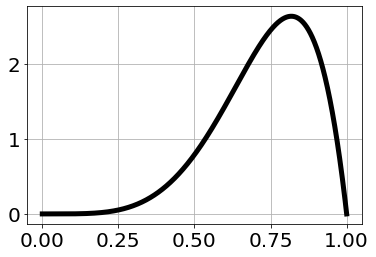

0.1963546866633984 optimized param prob_severe_s
0.20020020020020018 *mode value given a,b* 2 5


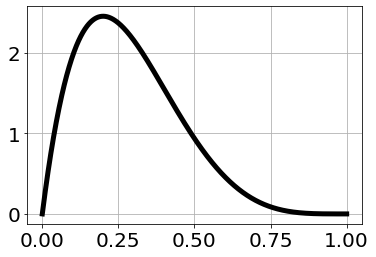

0.24598770477817747 optimized param prob_hosp_s
0.2502502502502503 *mode value given a,b* 2 4


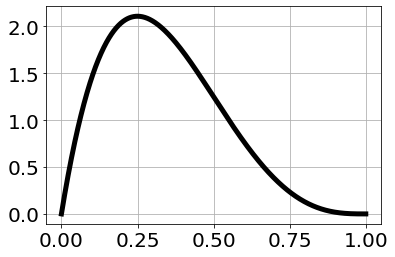

In [9]:
## TODO consider plotting the prior distrobutions and consider plotting posterior distribution

import numpy as np
from scipy.stats import beta
import matplotlib.pyplot as plt

fig, ax = plt.subplots(1, 1)

prior_params_ab = {'prob_sympt_s':[5.5,2],'prob_severe_s':[2,5],'prob_hosp_s':[2,4]}

        
for k,v in prior_params_ab.items():
    a = v[0]
    b = v[1]
    mean, var, skew, kurt = beta.stats(a, b, moments='mvsk')
#     print(mean,'*mean value given a,b*', a,b)
#     print(var,'*var value given a,b*', a,b)
    print(sigmoid(new_params[k]), 'optimized param', k)

    x = np.linspace(0,1,1000)
    pdf_vals = beta.pdf(x, a, b)
    imax = np.argmax(pdf_vals)
    print(x[imax],'*mode value given a,b*', a,b)
    plt.plot(x, pdf_vals,
           'k-', lw=5, label=k+' beta prior')
#     plt.vlines(sigmoid(new_params[k]),np.min(pdf_vals),beta.pdf(sigmoid(new_params[k]), a, b), label='optimized '+ k)

#     plt.legend(loc='best', frameon=False)

    plt.grid()
    plt.savefig(results_folder+state_short+'_prior_'+ k+'_'+str(training_mid_dates[0])+'_'+str(training_end_dates[0])  +'.pdf', bbox_inches='tight')
    plt.show()
    

4.693986464958364 1.0832804882575846 a,b
3.406570578343686 = optimized prob_soujourn_inf_alpha_s
mode value = 3.4084084084084085 vs opt 3.406570578343686


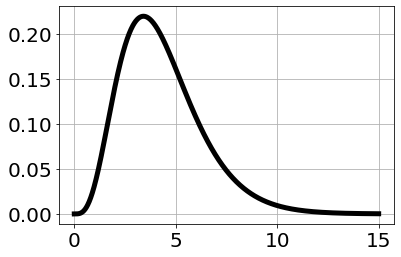

------
1.351693639556777 0.5813118009202929 a,b
0.6098167488414898 = optimized prob_soujourn_inf_beta_s
mode value = 0.6006006006006006 vs opt 0.6098167488414898


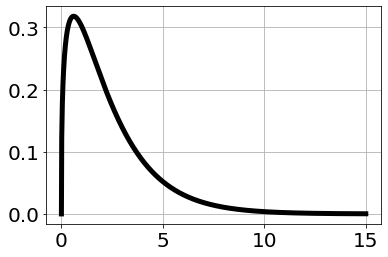

------
2.2019589211697066 0.741949951339325 a,b
1.6106539443388632 = optimized prob_soujourn_symp_alpha_s
mode value = 1.6216216216216217 vs opt 1.6106539443388632


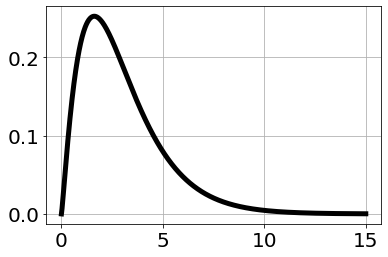

------
1.115102258598192 0.527992011918313 a,b
0.223054159322076 = optimized prob_soujourn_symp_beta_s
mode value = 0.22522522522522523 vs opt 0.223054159322076


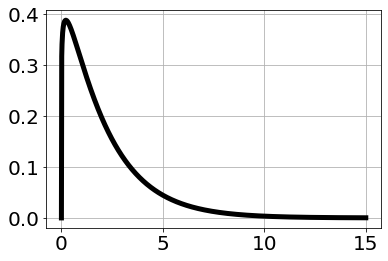

------


In [10]:
import numpy as np
from scipy.stats import gamma
# import matplotlib.pyplot as plt
import math
qfn = lambda a,b,c: [(-b + math.sqrt(b**2 - (4*a*c) )) / (2 * a),(-b - math.sqrt(b**2 - (4*a*c) )) / (2 * a)]

            # self.params['prob_soujourn_inf_alpha']= 3.41
    # self.params['prob_soujourn_inf_beta']= 0.605
    # self.params['prob_soujourn_symp_alpha']= 1.62
    # self.params['prob_soujourn_symp_beta']= 0.218
soj_new_params = [softplus(new_params['prob_soujourn_inf_alpha_s']),softplus(new_params['prob_soujourn_inf_beta_s']),
                  softplus(new_params['prob_soujourn_symp_alpha_s']),softplus(new_params['prob_soujourn_symp_beta_s'])
                 ]
soj_param_names = ['prob_soujourn_inf_alpha_s','prob_soujourn_inf_beta_s','prob_soujourn_symp_alpha_s','prob_soujourn_symp_beta_s']
for i,mode_value in enumerate([3.41,0.605,1.62,0.218]):
# for i,mode_value in enumerate([3.41,0.605,1.62,0.23]):
    betas = qfn(4,-mode_value,-1)
    beta = max(betas)

    a = 4*beta**2

    print(a,beta, 'a,b')
    print(soj_new_params[i], '= optimized', soj_param_names[i])

#     fig, ax = plt.subplots(1, 1)
    x = np.linspace(0,15, 1000)
    rv = gamma(a,scale=1/beta)
    pdf_vals = rv.pdf(x)
    imax = np.argmax(pdf_vals)
    
    plt.plot(x, pdf_vals, 'k-', lw=5, label='gamma prior')
    print('mode value = ' + str(x[imax]) + ' vs opt ' + str(soj_new_params[i]))
#     plt.vlines(soj_new_params[i], ymin=0,ymax=rv.pdf(soj_new_params[i]),label='optimized param')

#     plt.legend(loc='best', frameon=False)
#     plt.title('mode value = ' + str(mode_value) + ' vs opt ' + str(soj_new_params[i]))
    plt.grid()
    plt.savefig(results_folder+state_short+'_prior_'+ soj_param_names[i]+'_'+str(training_mid_dates[0])+'_'+str(training_end_dates[0])  +'.pdf', bbox_inches='tight')
    plt.show()
    
    print('------')

In [11]:
import os

import numpy as np


from scipy.special import gamma as gamma_fcn
from autograd_gamma import gammainc

from scipy.special import expit as sigmoid
from scipy.special import logit as sigmoid_inv
softplus = lambda x: np.log(1+np.exp(x))

softplus_inv = lambda x: np.log(np.exp(x) -1)
def log_gamma_pdf(x,alpha,beta):
    return alpha*np.log(beta) + (alpha-1)*np.log(x) - (beta*x) - np.log(gamma_fcn(alpha))

def gamma_at_x(params,x):
    if x==0:
        return 0.0 
    if x==1:
        return cdf_at_x(params,x)
    elif x>1:
        return cdf_at_x(params,x) - cdf_at_x(params,x-1)

def cdf_at_x(params,x):
    return (gammainc(params['alpha'],params['beta']*x))



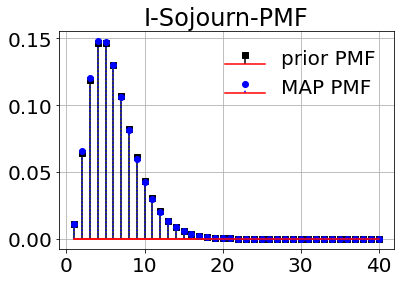

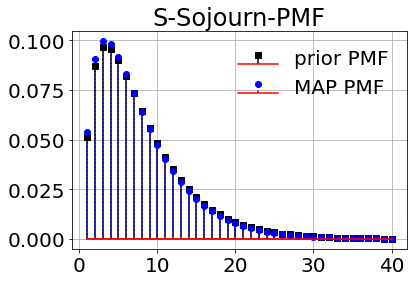

In [12]:
            # self.params['prob_soujourn_inf_alpha']= 3.41
    # self.params['prob_soujourn_inf_beta']= 0.605
    # self.params['prob_soujourn_symp_alpha']= 1.62
    # self.params['prob_soujourn_symp_beta']= 0.218
from matplotlib.pyplot import stem
########## INF SOJOURN
a = softplus(new_params['prob_soujourn_inf_alpha_s'])
beta = softplus(new_params['prob_soujourn_inf_beta_s'])
x = np.linspace(1,40, 40)
rv = gamma(a,scale=1/beta)
rv0 = gamma(3.41,scale=1/.605)

# plt.plot(x, rv.pdf(x), 'r-', lw=5, label='inf soj posterior')
# plt.plot(x, rv0.pdf(x), 'k-', lw=5, label='inf soj prior pdf')

stem(x, [gamma_at_x({'alpha':3.41,'beta':.605},val) for val in x], linefmt='k-', markerfmt='ks', basefmt='r-', label='prior PMF')
stem(x, [gamma_at_x({'alpha':a,'beta':beta},val) for val in x], linefmt='b:', markerfmt='bo', basefmt='r-', label='MAP PMF')
# plt.bar(x,[gamma_at_x({'alpha':a,'beta':beta},val) for val in x])
# plt.vlines(soj_new_params[i], ymin=0,ymax=rv.pdf(soj_new_params[i]),label='optimized param')
plt.title('I-Sojourn-PMF')
plt.legend(loc='best', frameon=False)
# plt.title('mode value = ' + str(mode_value) + ' vs opt ' + str(soj_new_params[i]))
plt.grid()
plt.savefig(results_folder+state_short+'_MAP_'+ '_I-Sojourn-PMF_'+'_'+str(training_mid_dates[0])+'_'+str(training_end_dates[0])  +'.pdf', bbox_inches='tight')
plt.show()
        
        
########## SYMP SOJOURN
                  
                  
a = softplus(new_params['prob_soujourn_symp_alpha_s'])
beta = softplus(new_params['prob_soujourn_symp_beta_s'])

x = np.linspace(1,40, 40)
rv = gamma(a,scale=1/beta)
rv0 = gamma(1.62,scale=1/.218)

# plt.plot(x, rv.pdf(x), 'r-', lw=5, alpha=0.6, label='symp soj posterior')
# plt.plot(x, rv0.pdf(x), 'k:', lw=3, label='symp soj prior')
# plt.vlines(soj_new_params[i], ymin=0,ymax=rv.pdf(soj_new_params[i]),label='optimized param')
stem(x, [gamma_at_x({'alpha':1.62,'beta':.218},val) for val in x], linefmt='k-', markerfmt='ks', basefmt='r-', label='prior PMF')
stem(x, [gamma_at_x({'alpha':a,'beta':beta},val) for val in x], linefmt='b:', markerfmt='bo', basefmt='r-', label='MAP PMF')
plt.title('S-Sojourn-PMF')

plt.legend(loc='best', frameon=False)
# plt.title('mode value = ' + str(mode_value) + ' vs opt ' + str(soj_new_params[i]))
plt.grid()
plt.savefig(results_folder+state_short+'_MAP_'+ '_S-Sojourn-PMF_'+'_'+str(training_mid_dates[0])+'_'+str(training_end_dates[0])  +'.pdf', bbox_inches='tight')
plt.show()